In [32]:
import pywt
import cv2
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

In [33]:
original = cv2.imread("E:/my_work_ding/libfacedetection-master/libfacedetection-master/testdata/test.png",0)

wavelet = 'bior4.4'
Np = 16
J = 4
s = 5
level = J
alpha = 0.5
beta = 4
cA_ = []
cH_ = []
cV_ = []
cD_ = []
original = cv2.resize(original, (512, 512), interpolation=cv2.INTER_CUBIC)

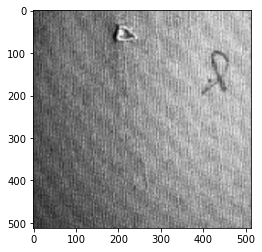

In [34]:
plt.imshow(original,  cmap = 'gray')

In [35]:
for i in range(level):
    if i == 0:
        coeffs = pywt.swt2(original, wavelet = wavelet, level = 1)
    else:
        coeffs = pywt.swt2(cA_[-1], wavelet = wavelet, level = 1)
        
    cA_.append(coeffs[0][0])
    H, V, D = coeffs[0][1]
    cH_.append(H)
    cV_.append(V)
    cD_.append(D)

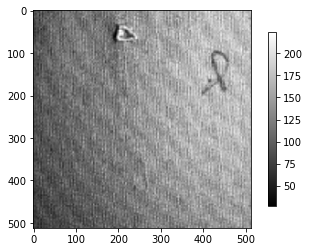

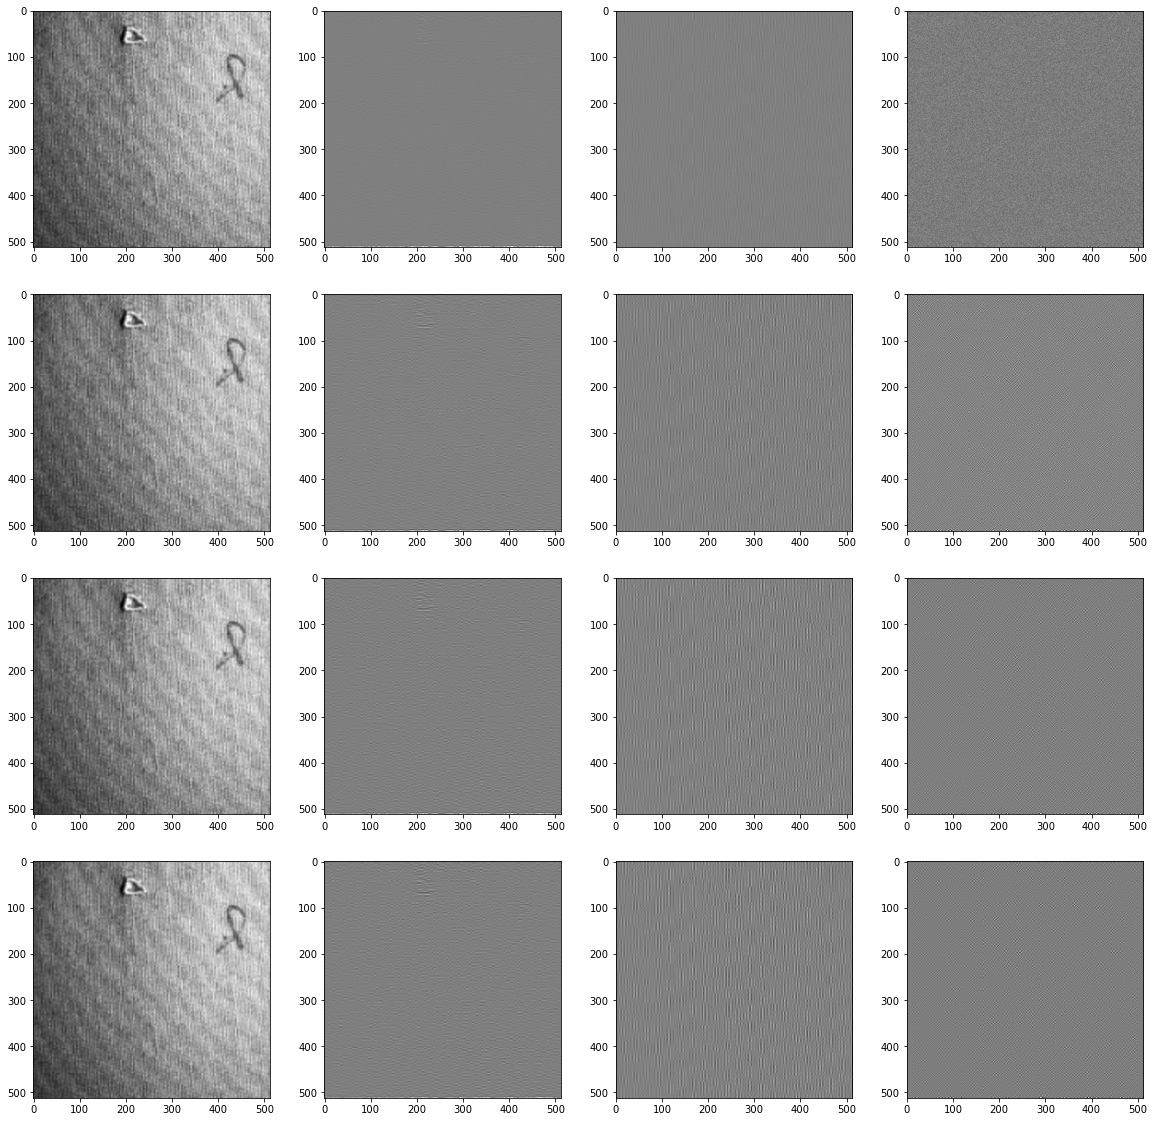

In [36]:
plt.imshow(original,  cmap = 'gray')
plt.colorbar(shrink=0.8)
fig = plt.figure(figsize=(20, 20))
for j in range(4):
    for i, a in enumerate([cA_[j], cH_[j], cV_[j], cD_[j]]):
        ax = fig.add_subplot(4, 4, i + 1 + j*4)
        ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)

In [37]:
kernel = np.ones([s,s], np.uint8)
dilate_image = cv2.dilate(cA_[-1], kernel, iterations = 1)
erode_image = cv2.erode(cA_[-1], kernel, iterations = 1)
M_l = cv2.absdiff(dilate_image, erode_image)

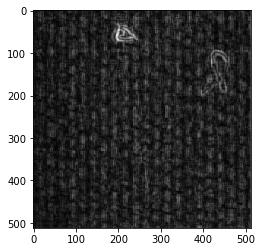

In [38]:
plt.imshow(M_l, cmap = 'gray')

In [39]:
Y_H = []
Y_V = []
Y_D = []

In [40]:
for j in range(level - 1):
    a = cv2.absdiff(cH_[j],cH_[j+1])
    #a = np.abs(cH_[j] -cH_[j+1])
    Y_H.append(a)
    a = cv2.absdiff(cV_[j], cV_[j+1])
    #a = np.abs(cV_[j] -cV_[j+1])
    Y_V.append(a)
    a = cv2.absdiff(cD_[j], cD_[j+1])
    #a = np.abs(cD_[j] -cD_[j+1])
    Y_D.append(a)

In [41]:
dst = np.array([])
M_h = cv2.add(Y_H[0], Y_H[1])
M_h = cv2.add(M_h, Y_H[2])
M_h = cv2.normalize(M_h, dst)

M_v = cv2.add(Y_V[0], Y_V[1])
M_v = cv2.add(M_v, Y_V[2])
M_v = cv2.normalize(M_v, dst)

M_d = cv2.add(Y_D[0], Y_D[1])
M_d = cv2.add(M_d, Y_D[2])
M_d = cv2.normalize(M_d, dst)

M_h = cv2.add(M_h, M_v)
M_h = cv2.add(M_h, M_d)

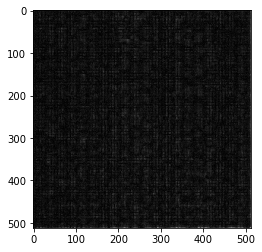

In [42]:
plt.imshow(M_h, cmap = 'gray')

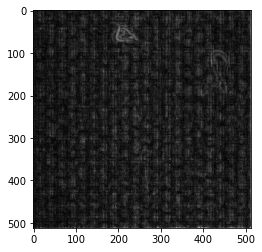

In [43]:
M = cv2.add(cv2.normalize(M_h, dst), cv2.normalize(M_l, dst))
plt.imshow(M, cmap = 'gray')

In [44]:
M.shape

(512, 512)

In [45]:
width_max, length_max = M.shape

In [46]:
import time
def Newton_method(Pk):
    app_u = 0.0001
    app_beta = 0.0001
    
    m, n = Pk.shape
    number = m*n
    p = Pk.reshape((-1,))
    
    #start_time = time.time()
    for i in range(1):
        
        Tvar = np.sum(list(map(lambda x: np.exp(-1 * x / app_beta) , p)))
        app_u = -1 * app_beta * np.log(1/number * Tvar)
        Xmean = np.mean(p)
        Tvar1 = np.sum(list(map(lambda x : x * np.exp(-1 * x / app_beta), p))) 
        app_beta = Xmean - Tvar1 / Tvar
    #print("time",time.time() - start_time)
    return app_u, app_beta

In [47]:
i, j = 0, 0
u_p = []
row, col = 0, 0
while row <= width_max:
    Row_u_p = []
    col = 0
    j = 0
    while col <= length_max:
        endi = row+Np
        endj = col+Np

        if endj > length_max:
            endj = length_max
        if endi > width_max:
            endi = width_max

        Pk = M[row:endi,col:endj]
        u, p = Newton_method(Pk)
        Row_u_p.append( (u, p) )
        
        j = j+1
        col = 0 + j * int((1-alpha) * Np)
    u_p.append(Row_u_p)
    i = i+1
    row = 0 + i * int((1-alpha) * Np)
    
u_p = np.array(u_p)      
    

ZeroDivisionError: division by zero

In [ ]:
mean_u = np.median(u_p[:,:,0])
mean_p = np.median(u_p[:,:,1])

In [ ]:
def log_ikelihood(Pk, mean_u, mean_p):
    m, n = Pk.shape
    number = m*n
    p = Pk.reshape((-1,))
    Lpk = -1*number*np.log(mean_p) + \
            np.sum(list(map(lambda x:(x-mean_u)/mean_p, p))) +  \
            np.sum(list(map(lambda x:np.exp(-1*(x-mean_u)/mean_p),p)))
    return Lpk

In [ ]:
M.reshape((-1,)).shape

In [ ]:
M.shape

In [ ]:
i, j = 0, 0
Lk = []
row, col = 0, 0
while row <= width_max:
    Row_lk = []
    col = 0
    j = 0
    while col <= length_max:
        endi = row+Np
        endj = col+Np

        if endj > length_max:
            endj = length_max
        if endi > width_max:
            endi = width_max

        Pk = M[row:endi,col:endj]
        L = log_ikelihood(Pk, mean_u, mean_p)
        Row_lk.append(L)
        
        j = j+1
        col = 0 + j * int((1-alpha) * Np)
    Lk.append(Row_lk)
    i = i+1
    row = 0 + i * int((1-alpha) * Np)
    
Lk = np.array(Lk)

In [ ]:
plt.imshow(M, cmap = 'gray')

In [ ]:
mL = np.mean(Lk)
thetaL = np.var(Lk) 

In [ ]:
i, j = 0, 0
row, col = 0, 0
while row <= width_max:
    col = 0
    j = 0
    while col <= length_max:
        endi = row+Np
        endj = col+Np

        if endj > length_max:
            endj = length_max
        if endi > width_max:
            endi = width_max

        Pk = M[row:endi,col:endj]
        Pk[np.abs(Lk[i,j] - mL) > beta*thetaL] = 1
        Pk[np.abs(Lk[i,j] - mL) <= beta*thetaL] = 0
        j = j+1
        col = 0 + j * int((1-alpha) * Np)
        
    i = i+1
    row = 0 + i * int((1-alpha) * Np)

In [ ]:
plt.imshow(M, cmap = 'gray')

In [ ]:
mL 

In [ ]:
thetaL

In [ ]:
beta